In [152]:
import torchaudio
torchaudio.set_audio_backend("soundfile")
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F
import torch
print(torch.__version__)
from torch import nn
from tqdm import tqdm
from torch.optim import Adam
import matplotlib.pyplot as plt
import os
import warnings
import gc
from copy import deepcopy
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import OneHotEncoder
import librosa
import numpy as np
import noisereduce as nr
warnings.filterwarnings("ignore")

1.8.0+cu111


# help function

In [153]:
def get_wav_freq(data, sample_rate,start_time=0,end_time=5000):
    start_point = int(sample_rate * start_time / 1000)
    end_point = int(sample_rate * end_time / 1000)-1
    length = (end_time - start_time) / 1000
    counter = 0
    for i in range(start_point, end_point):
        if data[i] < 0 and data[i+1] > 0:
            counter += 1
    return counter/length

def trim_and_padding(y,time_length = int(80000)):
    if 0 < len(y): 
        y, _ = librosa.effects.trim(y, top_db=20, frame_length=512, hop_length=64)
    if len(y) > time_length:
            y = y[0:0+time_length]
    else: # pad blank
        padding = time_length - len(y)
        offset = padding // 2
        y = np.pad(y, (offset, time_length - len(y) - offset))
    return y

def Shifting_Time(data, sampling_rate=16000, shift_max=1, shift_direction='both'):
    shift = np.random.randint(sampling_rate * shift_max)
    if shift_direction == 'right':
        shift = -shift
    elif shift_direction == 'both':
        direction = np.random.randint(0, 2)
        if direction == 1:
            shift = -shift
    augmented_data = np.roll(data, shift)
    if shift > 0:
        augmented_data[:shift] = 0
    else:
        augmented_data[shift:] = 0
    return augmented_data

def Changing_Pitch(data):
    return librosa.effects.pitch_shift(data,sr=16000,n_steps=np.random.choice([-3,-2,-1,1,2,3]))

def Changing_Speed(data):
    return librosa.effects.time_stretch(data, rate=np.random.choice([1.25,0.85]))

aug_method = {}
aug_method[0] = Shifting_Time
aug_method[1] = Changing_Pitch
aug_method[2] = Changing_Speed

# PATH

In [154]:
X_train_dir = 'train/train/'
X_test_dir = 'public_test/public_test/'
Y_train_path = 'train/meta_train.csv'

# wav 2 features flow

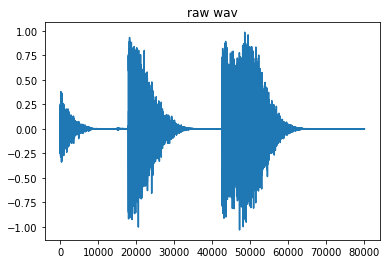

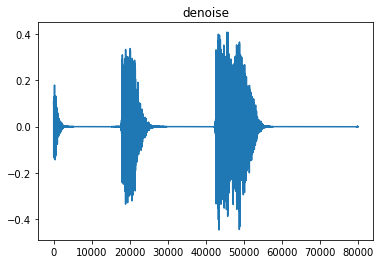

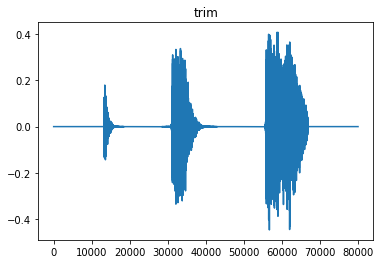

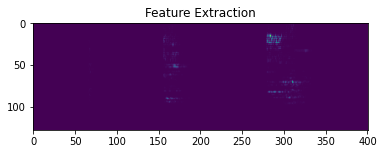

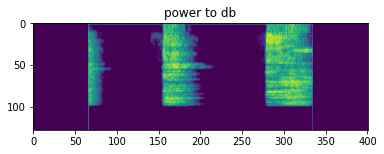

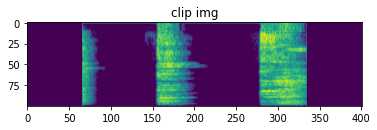

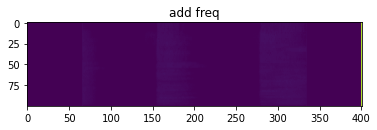

In [155]:
# raw wav
samples, sample_rate = librosa.load(X_train_dir+os.listdir(X_train_dir)[1],sr=16000)
plt.title('raw wav')
plt.plot(samples)
plt.show()

# denoise
noisy_part = samples[:]
reduced_noise = nr.reduce_noise(audio_clip=samples,noise_clip=noisy_part, verbose=False)
plt.title('denoise')
plt.plot(reduced_noise)
plt.show()

#trim these portions of the waveform
trimmed = trim_and_padding(reduced_noise)
plt.title('trim')
plt.plot(trimmed)
plt.show()

# Feature Extraction
melspectrogram = librosa.feature.melspectrogram(y=trimmed, sr=16000, S=None, n_fft=400, hop_length=400//2)
plt.title('Feature Extraction')
plt.imshow(melspectrogram)
plt.show()

# power to db
melspectrogram = librosa.power_to_db(melspectrogram, ref=np.max)
plt.title('power to db')
plt.imshow(melspectrogram)
plt.show()

# clip img
melspectrogram = melspectrogram[:100,:]
plt.title('clip img')
plt.imshow(melspectrogram)
plt.show()

# add freq info
melspectrogram[:,-1] = get_wav_freq(samples, sample_rate,start_time=0,end_time=5000)
plt.title('add freq')
plt.imshow(melspectrogram)
plt.show()

# wav data augmentation method

0


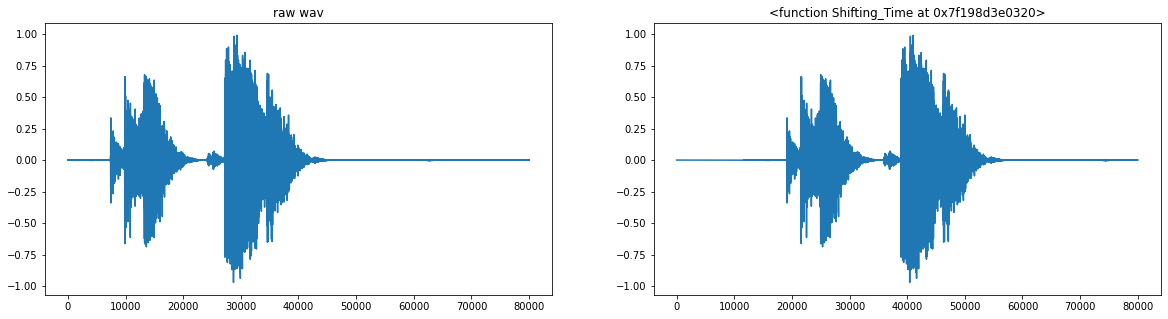

1


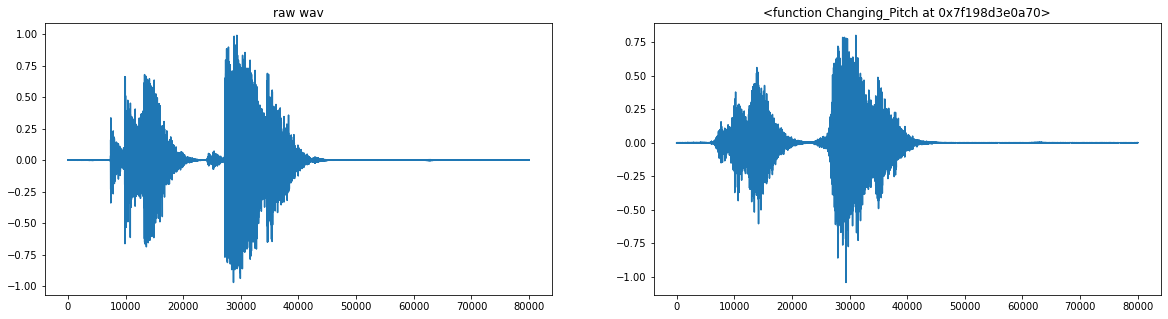

2


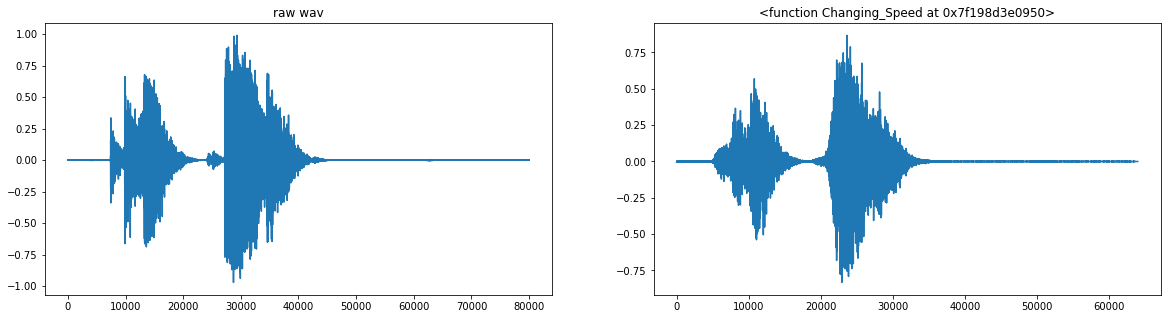

In [156]:
for k in aug_method.keys():
    print(k)
    plt.figure(figsize=(20,5))
    plt.subplot(1,2,1)
    samples, sample_rate = librosa.load(X_train_dir+os.listdir(X_train_dir)[0],sr=16000)
    plt.title('raw wav')
    plt.plot(samples)
    plt.subplot(1,2,2)
    samples = aug_method[k](samples)
    plt.title(str(aug_method[k]))
    plt.plot(samples)
    plt.show()

# preprocessing 

In [157]:
def sample2melspectrogram(samples,sample_rate):
    # 1.denoise
    reduced_noise = nr.reduce_noise(audio_clip=samples,noise_clip=samples[0:-1], verbose=False)
    # 2.trim
    trimmed = trim_and_padding(reduced_noise)
    # 3.Feature Extraction
    melspectrogram = librosa.feature.melspectrogram(y=trimmed, sr=16000, S=None, n_fft=400, hop_length=400//2)
    # 4.power to db
    melspectrogram = librosa.power_to_db(melspectrogram, ref=np.max)
    # 5.clip img
    melspectrogram = melspectrogram[:100,:]
    # 6.app freq
    melspectrogram[:,-1] = get_wav_freq(samples,sample_rate)
    return melspectrogram

def preprocessing_X(wav_dir):
    files = os.listdir(wav_dir)
    files.sort() #正確排序很重要
    X = torch.FloatTensor([])
    for f in tqdm(files):
        try:
            samples, sample_rate = librosa.load(wav_dir+f,sr=16000)
            mel_spectrogram = sample2melspectrogram(samples,sample_rate)
            shape = mel_spectrogram.shape
            mel_spectrogram = np.reshape(mel_spectrogram, (-1, shape[0], shape[1]))
            mel_spectrogram = torch.from_numpy(mel_spectrogram)
            X = torch.cat([X,torch.unsqueeze(mel_spectrogram,0)],dim=0)
        except:
            print(f)
    print('X shape:',X.shape)
    return X

def preprocessing_Y(file_path):
    Y = pd.read_csv(file_path)
    Y = Y[Y.Filename != 'train_01046']
    enc = OneHotEncoder().fit(Y[['Label']])
    Y_one_hot = enc.transform(Y[['Label']]).toarray()
    Y_one_hot = torch.FloatTensor(Y_one_hot)
    print('Y_ont_hot shape',Y_one_hot.shape)
    print('Y_df shape',Y.shape)
    return Y_one_hot,Y

def preprocessing_X_with_Augmentation(wav_dir,aug_method_idx=0):
    files = os.listdir(wav_dir)
    files.sort() #正確排序很重要
    X = torch.FloatTensor([])
    for f in tqdm(files):
        try:
            samples, sample_rate = librosa.load(wav_dir+f,sr=16000)
            aug_method[aug_method_idx](samples)
            mel_spectrogram = sample2melspectrogram(samples,sample_rate)
            shape = mel_spectrogram.shape
            mel_spectrogram = np.reshape(mel_spectrogram, (-1, shape[0], shape[1]))
            mel_spectrogram = torch.from_numpy(mel_spectrogram)
            X = torch.cat([X,torch.unsqueeze(mel_spectrogram,0)],dim=0)
        except:
            print(f)
    print('X shape:',X.shape)
    return X

# Load X

In [189]:
'''
X_train = preprocessing_X(X_train_dir)
X_train_aug0 = preprocessing_X_with_Augmentation(X_train_dir,aug_method_idx=0)
X_train_aug1 = preprocessing_X_with_Augmentation(X_train_dir,aug_method_idx=1)
X_train_aug2 = preprocessing_X_with_Augmentation(X_train_dir,aug_method_idx=2)
X_train = torch.cat([X_train,X_train_aug0,X_train_aug1,X_train_aug2],dim=0)
print(X_train.shape)
torch.save(X_train,'X_train.pt')
X_test = preprocessing_X(X_test_dir)
print(X_test.shape)
torch.save(X_test,'X_test.pt')
'''

"\nX_train = preprocessing_X(X_train_dir)\nX_train_aug0 = preprocessing_X_with_Augmentation(X_train_dir,aug_method_idx=0)\nX_train_aug1 = preprocessing_X_with_Augmentation(X_train_dir,aug_method_idx=1)\nX_train_aug2 = preprocessing_X_with_Augmentation(X_train_dir,aug_method_idx=2)\nX_train = torch.cat([X_train,X_train_aug0,X_train_aug1,X_train_aug2],dim=0)\nprint(X_train.shape)\ntorch.save(X_train,'X_train.pt')\nX_test = preprocessing_X(X_test_dir)\nprint(X_test.shape)\ntorch.save(X_test,'X_test.pt')\n"

In [190]:
import gc
gc.collect()

830

# load preprocessed features

In [191]:
if 'X_train.pt' in os.listdir():
    X_train = torch.load('X_train.pt')
    print('load')
print(X_train.shape)

load
torch.Size([4796, 1, 100, 401])


In [192]:
X_train = X_train[:1200-1]
X_train.shape

torch.Size([1199, 1, 100, 401])

In [193]:
if 'X_test.pt' in os.listdir():
    X_test = torch.load('X_test.pt')
    print('load')
print(X_test.shape)

load
torch.Size([10000, 1, 100, 401])


In [194]:
X_train = X_train[:,:,:,:-1]
X_train.shape

torch.Size([1199, 1, 100, 400])

In [195]:
X_test = X_test[:,:,:,:-1]
X_test.shape

torch.Size([10000, 1, 100, 400])

# load Y

In [196]:
Y_train,Y_train_df = preprocessing_Y(Y_train_path)
print(Y_train.shape)
map_dict = {}
for l in Y_train_df.Label.unique():
    map_dict[l] = Y_train_df[Y_train_df.Label==l].sample(1)['Remark'].values[0]
map_dict

Y_ont_hot shape torch.Size([1199, 6])
Y_df shape (1199, 3)
torch.Size([1199, 6])


{0: 'Barking',
 1: 'Howling',
 2: 'Crying',
 3: 'COSmoke',
 4: 'GlassBreaking',
 5: 'Vacuum'}

# look some sample

In [197]:
def plot_feature_by_class_name(class_name,X,label_df):
    try:
        plt.figure(figsize=(20,5))
        for i,filename in enumerate([i+'.wav' for i in label_df[label_df.Remark==class_name].sample(3)['Filename'].values]):
            feature = X[int(filename.split('_')[1].split('.')[0])]
            plt.subplot(1,3,i+1)
            plt.imshow(feature[0,:,:])
            title = 'class:{} filename:{}'.format(class_name,filename)
            plt.title(title)
        plt.tight_layout()
        plt.show()
    except:
        print(class_name)

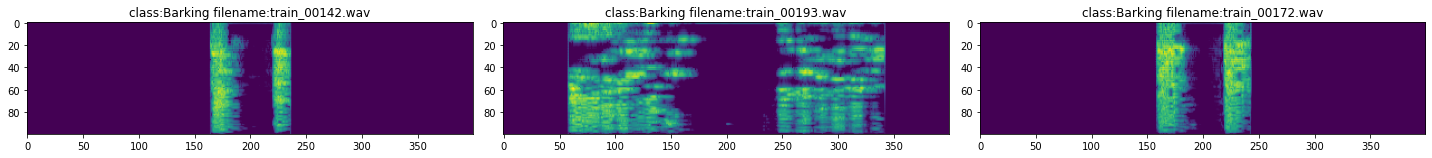

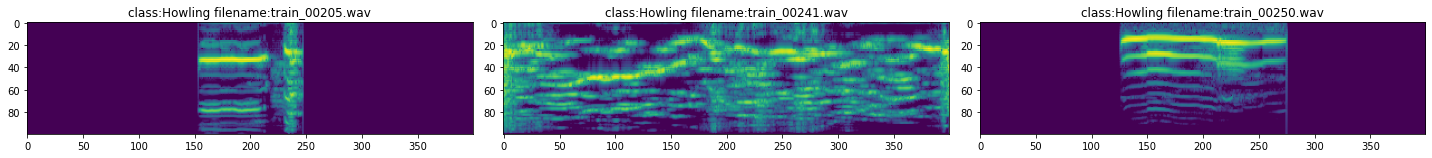

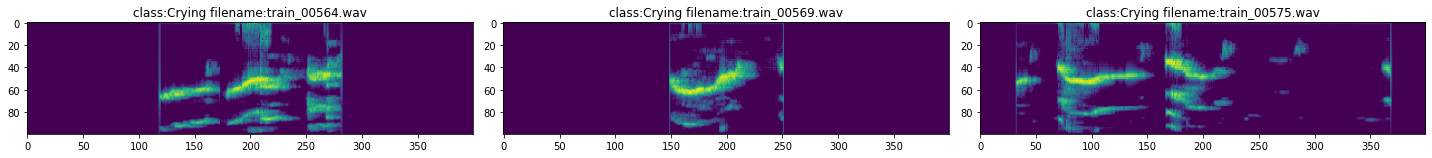

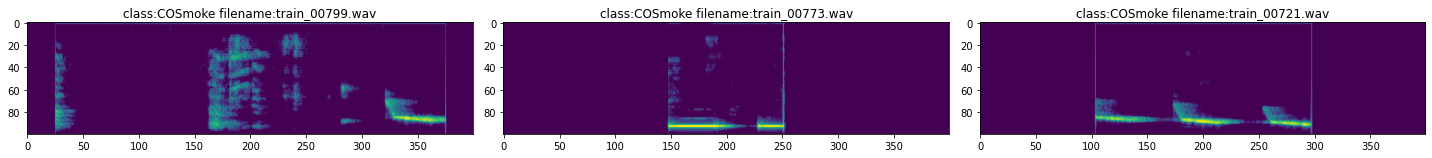

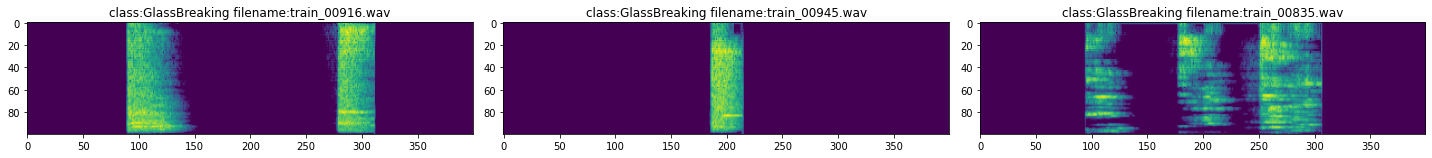

Other


<Figure size 1440x360 with 0 Axes>

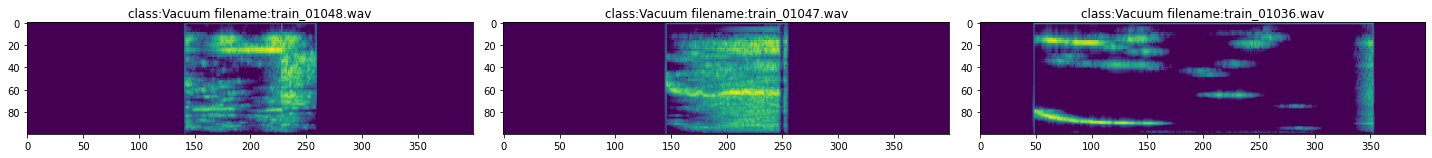

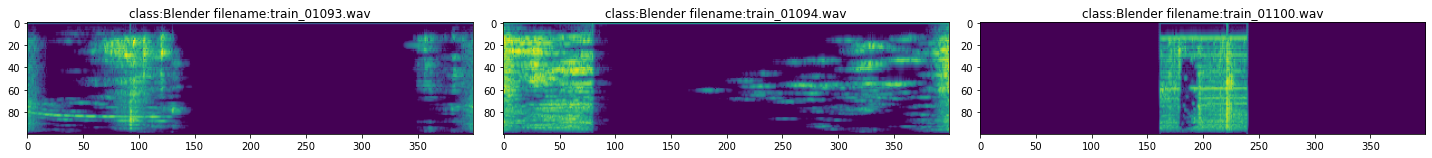

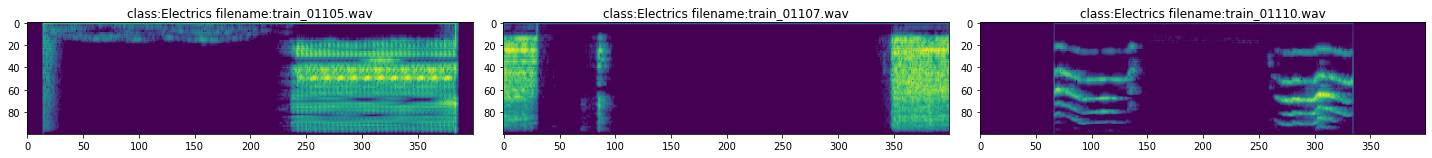

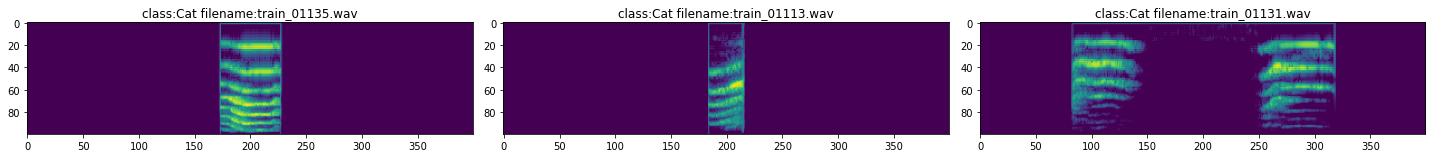

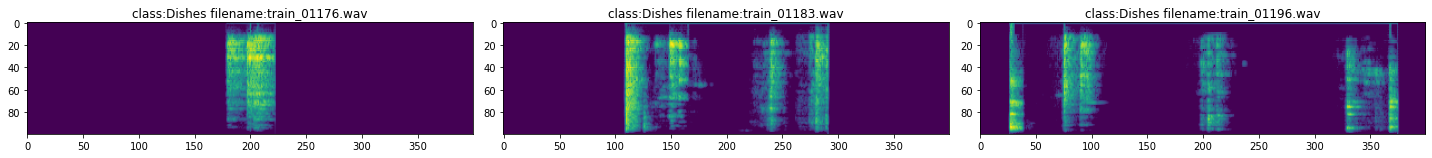

In [198]:
for class_name in Y_train_df.Remark.unique():
    plot_feature_by_class_name(class_name,X_train,Y_train_df)

# train valid split

In [199]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X_train, Y_train, test_size=0.2, random_state=42,stratify=Y_train)
print(pd.DataFrame(y_train.argmax(axis=1)).value_counts())
print(pd.DataFrame(y_valid.argmax(axis=1)).value_counts())

0    160
1    160
2    160
3    160
5    160
4    159
dtype: int64
0    40
1    40
2    40
3    40
4    40
5    40
dtype: int64


#  create pytorch dataloader and save

In [200]:
from torch.utils.data import TensorDataset,DataLoader
X_train = X_train.reshape(-1,1,100,400)
X_valid = X_valid.reshape(-1,1,100,400)
trainset = TensorDataset(torch.FloatTensor(X_train.to(torch.float32)),torch.FloatTensor(y_train))
vaildset = TensorDataset(torch.FloatTensor(X_valid.to(torch.float32)),torch.FloatTensor(y_valid))
train_iter = DataLoader(trainset,batch_size=128,num_workers=4)
vaild_iter = DataLoader(vaildset,batch_size=128,num_workers=4)
torch.save(train_iter, 'train_iter.pt')
torch.save(vaild_iter, 'vaild_iter.pt')
train_iter = torch.load('train_iter.pt')
vaild_iter = torch.load('vaild_iter.pt')

In [201]:
for bx,by in train_iter:
    print(bx.shape,bx.device) # batch,channel,freq,time
    print(by.shape,by.device) # batch,n_class
    break

torch.Size([128, 1, 100, 400]) cpu
torch.Size([128, 6]) cpu


# define model

In [204]:
model = torch.hub.load('pytorch/vision:v0.9.0', 'resnet50', pretrained=False)
model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model.fc = nn.Sequential(nn.Linear(2048,1024),nn.ReLU(),
                         nn.Linear(1024,512),nn.ReLU(),
                         nn.Linear(512,256),nn.ReLU(),
                         nn.Linear(256,128),nn.ReLU(),
                         nn.Linear(128,6),nn.Softmax(dim=1))
print(model)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.9.0


ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

# model forward test

In [205]:
y_hat = model(bx)
print(bx.shape,y_hat.shape)
y_hat.shape

torch.Size([128, 1, 100, 400]) torch.Size([128, 6])


torch.Size([128, 6])

# def train loop

In [206]:
def train_step(model,train_iter,loss_fn,optimizer,device):
        model.train()
        total_loss = 0
        total_auc = 0
        for t,(x,y) in enumerate(train_iter):
            x,y = x.to(device),y.to(device)
            y_hat = model(x)
            total_auc += calculate_auc_score(model,x,y)
            loss = loss_fn(y_hat,y)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            total_loss += loss.item()
        return total_loss/(t+1) ,total_auc/(t+1)

def valid_step(model,vaild_iter,loss_fn,optimizer,device):
    model.eval()
    total_loss = 0
    total_auc = 0
    for t,(x,y) in enumerate(vaild_iter):
        x,y = x.to(device),y.to(device)
        y_hat = model(x)
        total_auc += calculate_auc_score(model,x,y)
        loss = loss_fn(y_hat,y)
        total_loss += loss.item()
    return total_loss/(t+1) ,total_auc/(t+1)

def softmax2onehot(probs):
  probs = torch.FloatTensor(probs)
  max_idx = torch.argmax(probs, 1, keepdim=True)
  one_hot = torch.FloatTensor(probs.shape)
  one_hot.zero_()
  one_hot.scatter_(1, max_idx, 1)
  return one_hot.detach().cpu().numpy().astype(int)

# calculate roc_auc_score
def calculate_auc_score(model,x,y):
    y_hat = model(x).detach().cpu().numpy()
    y = y.detach().cpu().numpy()
    return 0 #roc_auc_score(y_hat,y)


# train_loop
def train(model,train_iter,vaild_iter,optimizer,loss_fn,max_epochs=300,log_interval=10,device=None):
        history = {
            'train_loss':[],
            'valid_loss':[],
            'train_auc':[],
            'valid_auc':[],
            }
        current_loss = np.inf
        best_model = None
        for i in tqdm(range(max_epochs)):
            # step
            train_loss,train_auc = train_step(model,train_iter,loss_fn,optimizer,device)
            valid_loss,valid_auc = valid_step(model,vaild_iter,loss_fn,optimizer,device)
            # record history
            history['train_loss'].append(train_loss)
            history['valid_loss'].append(valid_loss)
            history['train_auc'].append(train_auc)
            history['valid_auc'].append(valid_auc)
            # print info
            if i % log_interval == 0:
                print("epoch:{} train_loss:{:.4f} valid_loss:{:.4f} train_auc:{:.4f} valid_auc:{:.4f}".format(
                    i,history['train_loss'][-1],history['valid_loss'][-1],history['train_auc'][-1],history['valid_auc'][-1])
                    )
            # record the best model
            if history['valid_loss'][-1] <= current_loss:
                best_model = deepcopy(model.eval())
                current_loss = history['valid_loss'][-1]
            gc.collect()
        # copy best model
        model = deepcopy(best_model.eval())
        
        # plot
        plt.plot(history['train_loss'],label='train_loss')
        plt.plot(history['valid_loss'],label='valid_loss')
        plt.legend()
        plt.savefig('loss.jpg')
        plt.show()
        
        
        plt.plot(history['train_auc'],label='train_auc')
        plt.plot(history['valid_auc'],label='valid_auc')
        plt.legend()
        plt.savefig('auc.jpg')
        plt.show()
        
        
        return model

  0%|          | 0/100 [00:00<?, ?it/s]

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

  1%|          | 1/100 [00:09<16:24,  9.94s/it]

epoch:0 train_loss:0.7458 valid_loss:0.7502 train_auc:0.0000 valid_auc:0.0000


 11%|█         | 11/100 [01:55<15:17, 10.31s/it]

epoch:10 train_loss:0.6802 valid_loss:0.6985 train_auc:0.0000 valid_auc:0.0000


 21%|██        | 21/100 [03:41<13:46, 10.46s/it]

epoch:20 train_loss:0.6777 valid_loss:0.6908 train_auc:0.0000 valid_auc:0.0000


 31%|███       | 31/100 [05:26<11:43, 10.19s/it]

epoch:30 train_loss:0.6846 valid_loss:0.6953 train_auc:0.0000 valid_auc:0.0000


 41%|████      | 41/100 [07:10<10:16, 10.44s/it]

epoch:40 train_loss:0.6765 valid_loss:0.6820 train_auc:0.0000 valid_auc:0.0000


 51%|█████     | 51/100 [08:55<08:34, 10.49s/it]

epoch:50 train_loss:0.6849 valid_loss:0.6966 train_auc:0.0000 valid_auc:0.0000


 61%|██████    | 61/100 [10:40<06:53, 10.60s/it]

epoch:60 train_loss:0.6809 valid_loss:0.6973 train_auc:0.0000 valid_auc:0.0000


 71%|███████   | 71/100 [12:26<05:04, 10.50s/it]

epoch:70 train_loss:0.6958 valid_loss:0.7028 train_auc:0.0000 valid_auc:0.0000


 81%|████████  | 81/100 [14:14<03:27, 10.94s/it]

epoch:80 train_loss:0.7053 valid_loss:0.7510 train_auc:0.0000 valid_auc:0.0000


 91%|█████████ | 91/100 [16:00<01:37, 10.80s/it]

epoch:90 train_loss:0.6887 valid_loss:0.6919 train_auc:0.0000 valid_auc:0.0000


100%|██████████| 100/100 [17:33<00:00, 10.54s/it]


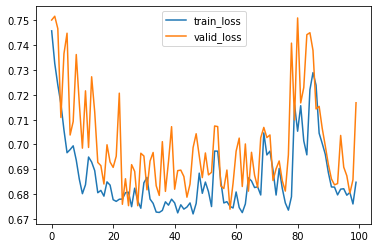

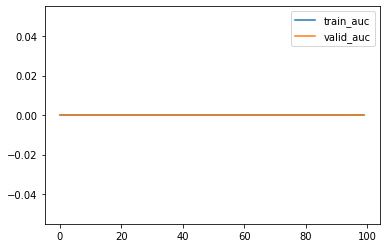

train done


In [207]:
device = 'cuda:0'
model = model.to(device)
print(model)
model = torch.nn.DataParallel(model, device_ids=[0, 1, 2 ,3])
optimizer = Adam(model.parameters(),lr=1e-3)
loss_fn = nn.BCEWithLogitsLoss()
model = train(model,train_iter,vaild_iter,optimizer,loss_fn,max_epochs=100,log_interval=10,device=device)
torch.save(model,'model.pt')
print('train done')

# model infernce test

In [214]:
from sklearn.metrics import confusion_matrix,accuracy_score
def plot_confusion_matrix(model,data_iter,map_dict=map_dict):
    y_true = np.array([])
    y_pred = np.array([])
    for bx,by in tqdm(data_iter):
        bx = bx.to(device)
        by = by.to(device)
        y_hat = model(bx)
        try:
            if len(y_true) == 0:
                y_true = by.argmax(axis=1).detach().cpu().numpy()
                y_pred = y_hat.argmax(axis=1).detach().cpu().numpy()
            else:
                y_true = np.hstack((y_true,by.argmax(axis=1).detach().cpu().numpy()))
                y_pred = np.hstack((y_pred,y_hat.argmax(axis=1).detach().cpu().numpy()))
        except:
            pass
    cm = pd.DataFrame(confusion_matrix(y_pred,y_true))
    cm.columns = list(map_dict.values())
    acc = accuracy_score(y_pred,y_true)
    return cm,acc

In [216]:
cm,acc = plot_confusion_matrix(model,train_iter)
cm.style.background_gradient(),acc

100%|██████████| 8/8 [00:03<00:00,  2.50it/s]


(<pandas.io.formats.style.Styler at 0x7f198d4951d0>, 0.7664233576642335)

In [217]:
cm,acc = plot_confusion_matrix(model,vaild_iter)
cm.style.background_gradient(),acc

100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


(<pandas.io.formats.style.Styler at 0x7f19cffc10d0>, 0.7416666666666667)

In [218]:
model = model.to('cpu')
torch.save(model,'model_2021_0602_1204_acc_0.7416.pt')
print('model save done')

model save done


# submit

In [219]:
print(X_test.shape[0])

10000


In [220]:
# load model
sample_submit = pd.read_csv('sample_submission.csv')
model = torch.load('model_2021_0602_1204_acc_0.7416.pt').cuda()
batch = 100
for i in tqdm(range(0,X_test.shape[0]-batch+1,batch)):
    sample_submit.iloc[i:i+batch,1:] = model(X_test[i:i+batch].to(torch.float32).cuda()).detach().cpu().numpy()
sample_submit

100%|██████████| 100/100 [00:14<00:00,  7.03it/s]


,Filename,Barking,Howling,Crying,COSmoke,GlassBreaking,Other
0,public_00001,2.173641e-07,1.934015e-17,2.854990e-15,1.018135e-12,8.518518e-11,9.999998e-01
1,public_00002,1.221360e-03,4.186358e-08,1.357289e-06,1.568542e-06,3.225823e-06,9.987724e-01
2,public_00003,1.000000e+00,3.122495e-14,2.257736e-28,5.806517e-28,1.043876e-18,1.058724e-14
3,public_00004,9.528698e-07,6.121301e-14,5.780325e-12,5.287007e-10,1.606268e-09,9.999990e-01
4,public_00005,5.949846e-07,1.730112e-04,9.998081e-01,3.158937e-06,1.734915e-09,1.510453e-05
...,...,...,...,...,...,...,...
29995,private_19996,1.666000e-01,1.666000e-01,1.666000e-01,1.666000e-01,1.666000e-01,1.670000e-01
29996,private_19997,1.666000e-01,1.666000e-01,1.666000e-01,1.666000e-01,1.666000e-01,1.670000e-01
29997,private_19998,1.666000e-01,1.666000e-01,1.666000e-01,1.666000e-01,1.666000e-01,1.670000e-01
29998,private_19999,1.666000e-01,1.666000e-01,1.666000e-01,1.666000e-01,1.666000e-01,1.670000e-01


In [221]:
# save
sample_submit.to_csv('submit_2021_0602_1204_acc_0.7416.csv',index=False)
print('done')

done
